In [1]:
# Basic Libs
import os
import random
import numpy as np
import pandas as pd

# Image Process
from skimage.data import imread
from skimage.morphology import label

# Model Framework
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# Helper Function
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm
from src.pipeline import *
from src.evaluation import *
from src.preprocess import *

Using TensorFlow backend.


# Read Data

In [2]:
input_dir = './src/'
train_img_dir = './assets/'

In [3]:
train_df = pd.read_csv(input_dir+'demo_imgs.csv')

In [4]:
train_df['area'] = train_df['EncodedPixels'].apply(calc_area_for_rle)
train_gp = train_df.groupby('ImageId').sum()
train_gp = train_gp.reset_index()
train_gp['class'] = train_gp['area'].apply(calc_class)

In [5]:
train_df_isship = train_df[train_df['area'] > 0]
# Filter data by area less than 10
train_df_smallarea = train_df_isship['area'][train_df_isship['area'] < 10]

# Define Model - U-Net

In [6]:
inputs = Input(shape=(768,768,3))
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)

comp0 = AveragePooling2D((6,6))(conv0)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6),interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 768, 8)  584         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

batch_normalization_14 (BatchNo (None, 16, 16, 128)  512         conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 128)  147584      batch_normalization_14[0][0]     
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 16, 16, 128)  512         conv2d_15[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_2 (UpSampling2D)  (None, 32, 32, 128)  0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 64)   32832       up_sampling2d_2[0][0]            
__________________________________________________________________________________________________
batch_norm

In [8]:
model.load_weights('./models/checkpoint_baseline.hdf5')
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# Show Some Prediction

In [9]:
val_list = train_gp['ImageId'].tolist()
opt_threshold = 0.5

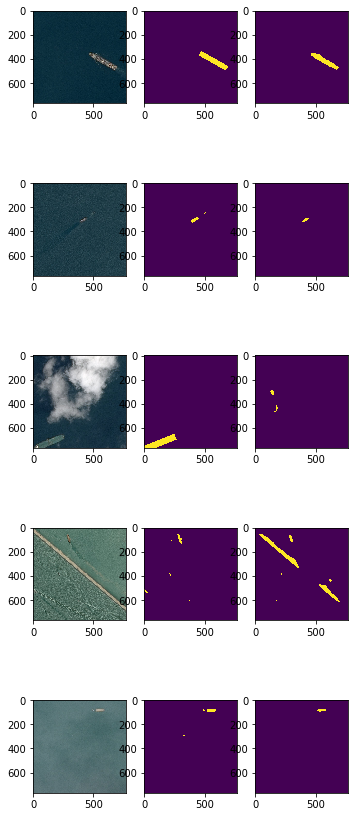

In [10]:
image_list = val_list
fig, axes = plt.subplots(len(image_list), 3, figsize=(5,5*len(image_list)))
fig.subplots_adjust(left=0.075,right=0.95,bottom=0.05,top=0.52,wspace=0.2,hspace=0.10)
for i in range(len(image_list)):
    img = imread(train_img_dir + image_list[i])
    input_img, gt_mask = create_data([image_list[i]], train_img_dir, train_df)
    pred_mask = model.predict(input_img)
    pred_mask = pred_mask > opt_threshold
    pred_mask = pred_mask.reshape(768,768,1)
    gt_mask = gt_mask * 255
    gt_mask = gt_mask.reshape(768,768)
    pred_mask = pred_mask.reshape(768,768)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(gt_mask)
    axes[i, 2].imshow(pred_mask)

# Define Model - Res-U-Net

In [11]:
inputs = Input(shape=(768,768,3))

#768
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)
comp0 = AveragePooling2D((6,6))(conv0)

# 384
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
plus_1 = concatenate([conv1, comp0], axis=3)
conv1 = BatchNormalization()(plus_1)
conv1 = Dropout(0.4)(conv1)

# 192
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
plus_2 = concatenate([conv2, pool1], axis=3)
conv2 = BatchNormalization()(plus_2)
conv2 = Dropout(0.4)(conv2)

# 96
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
plus_3 = concatenate([conv3, pool2], axis=3)
conv3 = BatchNormalization()(plus_3)
conv3 = Dropout(0.4)(conv3)

# 48
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
plus_4 = concatenate([conv4, pool3], axis=3)
conv4 = BatchNormalization()(plus_4)
conv4 = Dropout(0.4)(conv4)

# 24
pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
plus_5 = concatenate([conv5, pool4], axis=3)
conv5 = BatchNormalization()(plus_5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6),interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 768, 768, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 768, 768, 8)  32          conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 768, 768, 8)  584         batch_normalization_27[0][0]     
__________________________________________________________________________________________________
batch_norm

                                                                 max_pooling2d_8[0][0]            
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 8, 8, 504)    2016        concatenate_10[0][0]             
__________________________________________________________________________________________________
up_sampling2d_6 (UpSampling2D)  (None, 16, 16, 504)  0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 16, 16, 128)  258176      up_sampling2d_6[0][0]            
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 16, 16, 128)  512         conv2d_40[0][0]                  
__________________________________________________________________________________________________
concatenat

__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 768, 768, 8)  32          conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 768, 768, 1)  9           batch_normalization_52[0][0]     
Total params: 2,618,745
Trainable params: 2,614,329
Non-trainable params: 4,416
__________________________________________________________________________________________________


In [13]:
model.load_weights('./models/deepU_BenchModel.hdf5')
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# Show Some Prediction

In [14]:
val_list = train_gp['ImageId'].tolist()
opt_threshold = 0.7

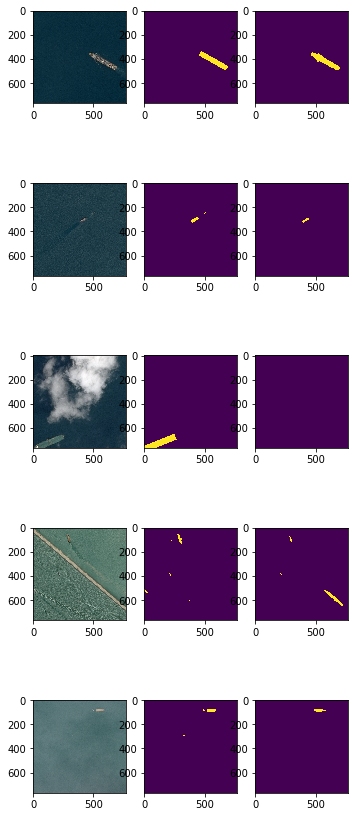

In [15]:
image_list = val_list
fig, axes = plt.subplots(len(image_list), 3, figsize=(5,5*len(image_list)))
fig.subplots_adjust(left=0.075,right=0.95,bottom=0.05,top=0.52,wspace=0.2,hspace=0.10)
for i in range(len(image_list)):
    img = imread(train_img_dir + image_list[i])
    input_img, gt_mask = create_data([image_list[i]], train_img_dir, train_df)
    pred_mask = model.predict(input_img)
    pred_mask = pred_mask > opt_threshold
    pred_mask = pred_mask.reshape(768,768,1)
    gt_mask = gt_mask * 255
    gt_mask = gt_mask.reshape(768,768)
    pred_mask = pred_mask.reshape(768,768)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(gt_mask)
    axes[i, 2].imshow(pred_mask)